### Check type of GPU and VRAM available.

In [ ]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

A100-SXM4-40GB, 40536 MiB, 40536 MiB


### Connect to AWS
- Add your key and secret key as 
````
%%writefile ~/.passwd-s3fs
<key>:<secret_key>
````

In [ ]:
%%writefile ~/.passwd-s3fs
# ADD here <key>:<secret>

Writing /root/.passwd-s3fs


In [ ]:
!chmod 600 ~/.passwd-s3fs
!apt install s3fs
!mkdir /s3         
!s3fs sagemaker-user-training /s3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  s3fs
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 234 kB of archives.
After this operation, 678 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 s3fs amd64 1.86-1 [234 kB]
Fetched 234 kB in 1s (283 kB/s)
Selecting previously unselected package s3fs.
(Reading database ... 129504 files and directories currently installed.)
Preparing to unpack .../archives/s3fs_1.86-1_amd64.deb ...
Unpacking s3fs (1.86-1) ...
Setting up s3fs (1.86-1) ...
Processing triggers for man-db (2.9.1-1) ...


Tankred model path:
o8uKNXLy5AYG3D9BvYMXHfBVQW23/3df8359f7e6d467abedbe7965d43672d/output/model.tar.gz

In [ ]:
!cp /s3/2d5T1iDG2YR1ZL8GQs9rNTHS7Ot1/af1cb29f056d4124a63acad7b462d3c2/output/model.tar.gz /content/

In [ ]:
!tar -xf /content/model.tar.gz

### Install Dependencies

In [ ]:
!git clone https://github.com/Jan-Oliver/profaile-pic-dev.git
!cd /content/profaile-pic-dev && pip install -r requirements.txt

Cloning into 'profaile-pic-dev'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 176 (delta 3), reused 8 (delta 3), pack-reused 168
Receiving objects: 100% (176/176), 52.56 MiB | 42.31 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-mv8_dy5b
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-mv8_dy5b
  Resolved https://github.com/huggingface/diffusers.git to commit 31336dae3b95a60069fc08ed4024b14f9b71fc11
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-gl5udeq7
  Running command git

### Util functions

In [ ]:
# Util functions
from PIL import Image
import os
import glob
import tqdm
import shutil

PRECISION="fp16"
if PRECISION == "fp16":
    fp16 = True
else:
    fp16 = False

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

### Directories

In [ ]:
# Leave name as it is -> Generic name we use at the moment independant of actual user name
MODEL_DIR = "/content/"

### Inference

In [ ]:
import torch
from torch import autocast
from IPython.display import display
from diffusers import DDIMScheduler, StableDiffusionPipeline

scheduler_ddim = DDIMScheduler.from_pretrained(MODEL_DIR,subfolder="scheduler")

# First for Euler
if PRECISION == "fp16":
  pipe = StableDiffusionPipeline.from_pretrained(MODEL_DIR, scheduler=scheduler_ddim, safety_checker=None, torch_dtype=torch.float16).to("cuda")
else:
  pipe = StableDiffusionPipeline.from_pretrained(MODEL_DIR, scheduler=scheduler_ddim, safety_checker=None, torch_dtype=torch.float32).to("cuda")

In [ ]:
prompts_woman = {
    "1": { # Amazing
        "positive_prompt": "A cinematic film still of qonvhs woman, portrait, 40mm lens, shallow depth of field, close up, studio lighting",
        "negative_prompt": "blender, makeup, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    },
    "2": { # Amazing
        "positive_prompt": "Portrait photo of qonvhs woman with a beautiful natural face, closeup, close-up, natural light, bokeh, highly detailed skin, HDR, UHD, 64K",
        "negative_prompt": "blender, ugly, makeup, low resolution, boring, bad anatomy, blender, multiple hands, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    },
    "3": { # Tested
        "positive_prompt": "A cinematic film still of qonvhs woman with her dog, beautiful natural face, portrait, 40mm lens, shallow depth of field, close up, studio lighting",
        "negative_prompt": "blender, makeup, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    },
    "4": { # Tested
        "positive_prompt": "Close-up front portrait photo of qonvhs woman with beautiful natural face, my favorite image, photograph 35mm f1.4 Kodak portra 400, natural light, bokeh, HDR, UHD, 64K",
        "negative_prompt": "blender, bad teeth, makeup, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    },
    "5": { # Tested
        "positive_prompt": "A cinematic film still of qonvhs woman with her cat, beautiful natural face, portrait, 40mm lens, shallow depth of field, close up, studio lighting",
        "negative_prompt": "blender, makeup, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    },
    "6": { # Tested
        "positive_prompt": "Close-up studio portrait of qonvhs woman with beautiful natural face, my favorite image, detail, influencer, studio lighting, photograph 35mm f1.4 Kodak portra 400 HDR, UHD, 64K",
        "negative_prompt": "blender, high contrast, watermark, bad teeth, makeup, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    }
}


In [ ]:
prompts_man = {
    "1": { # Tested
        "positive_prompt": "A cinematic film still of qonvhs man, portrait, 40mm lens, shallow depth of field, close up, studio lighting",
        "negative_prompt": "blender, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    },
    "2": { # Tested
        "positive_prompt": "A professional realistic photography of qonvhs man wearing a suit, head-shot, natural light, bokeh, highly detailed skin, HDR, UHD, 64K",
        "negative_prompt": "ugly, low resolution, teeth, boring, bad anatomy, blender, multiple hands, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    },
    "3": { # Tested
        "positive_prompt": "A professional realistic photography of qonvhs man wearing a tailored white shirt, head-shot, relaxed pose, favourite image, natural light, bokeh, highly detailed skin, HDR, UHD, 64K",
        "negative_prompt": "blender, ugly, teeth, low resolution, bad anatomy, blender, multiple hands, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    },
    "4": { # Tested
        "positive_prompt": "A professional realistic photography of qonvhs man playing with his cute cat, laughing into the camera, head shot, golden hour, my favourite image, symmetrical, bokeh, 40mm lens, hasselblad, HDR, UHD, 64K",
        "negative_prompt": "multiple people, teeth, blender, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    },
    "5": { # Tested
        "positive_prompt": "A professional realistic photography of qonvhs man playing with his cute dog, laughing into the camera, head shot, golden hour, my favourite image, symmetrical, bokeh, 40mm lens, hasselblad, HDR, UHD, 64K",
        "negative_prompt": "multiple people, teeth, blender, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    },
    "6": { # Tested
        "positive_prompt": "A professional realistic photography of qonvhs man, head shot, relaxed pose, favourite image, deep focus, symmetrical, natural face, bokeh, natural lightning, 40mm lens, hasselblad, HDR, UHD, 64K",
        "negative_prompt": "multiple bodies, teeth, blender, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
    }
}
# detailed photograph of an older woman/man wearing a leather jacket, waist shot, forest background, in the style of Brandon Stanton, Humans of New York
# portrait photograph of a happy, pensive older woman/man wearing a leather jacket, forest background, close up, black and white, wide aperture, 8K, sharp edges, Robert Doisneau

  0%|          | 0/70 [00:00<?, ?it/s]

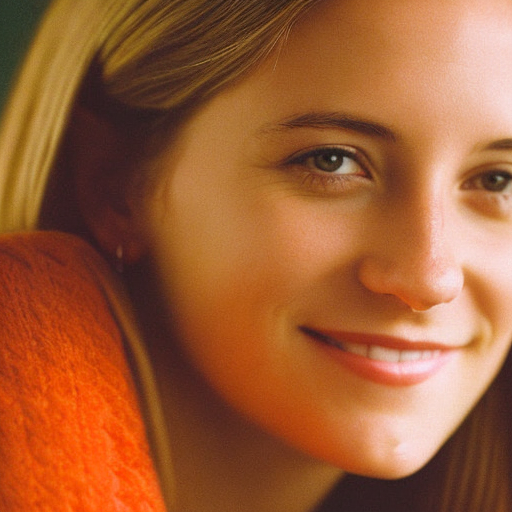

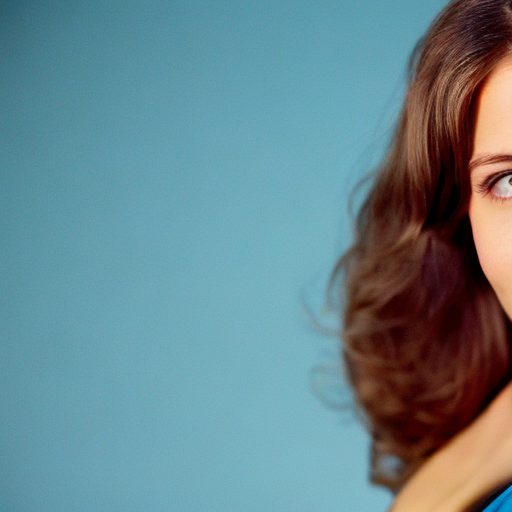

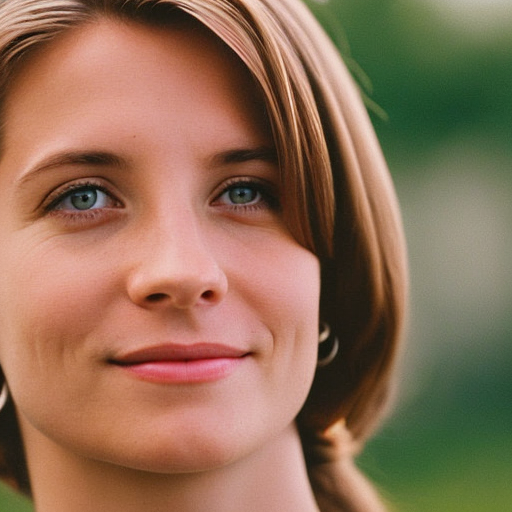

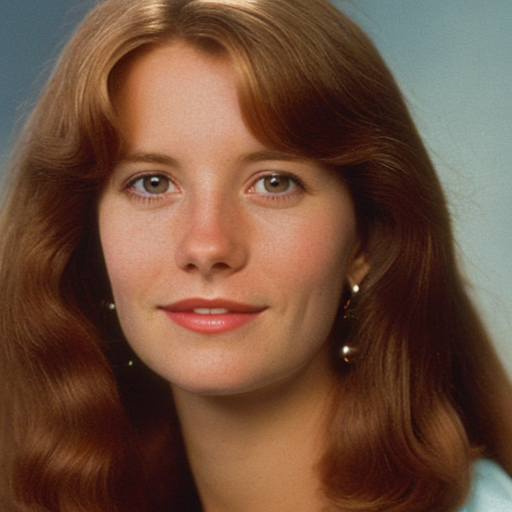

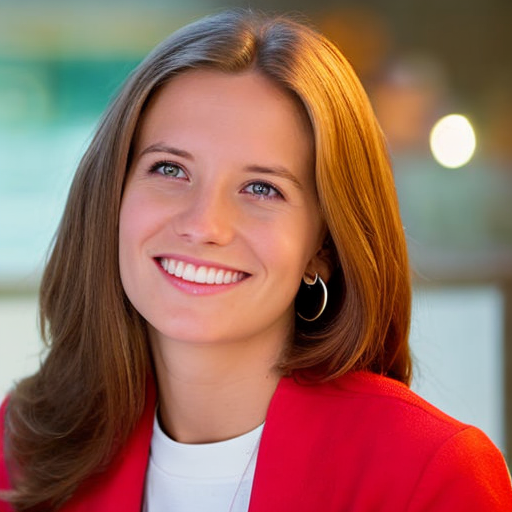

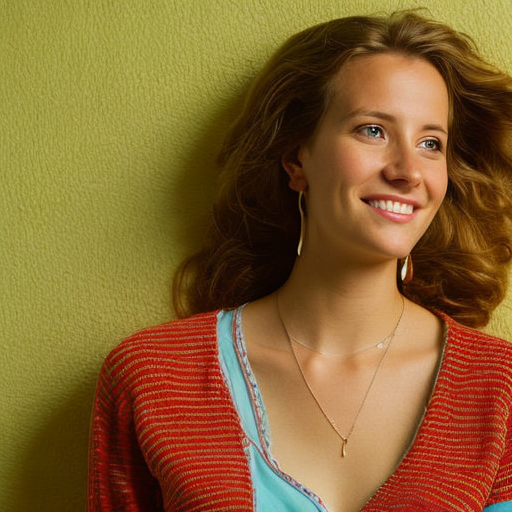

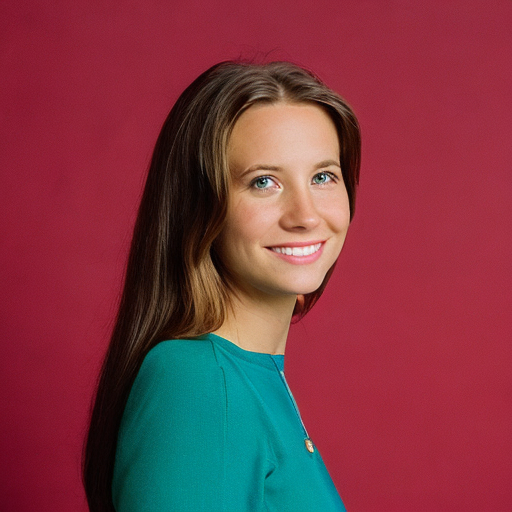

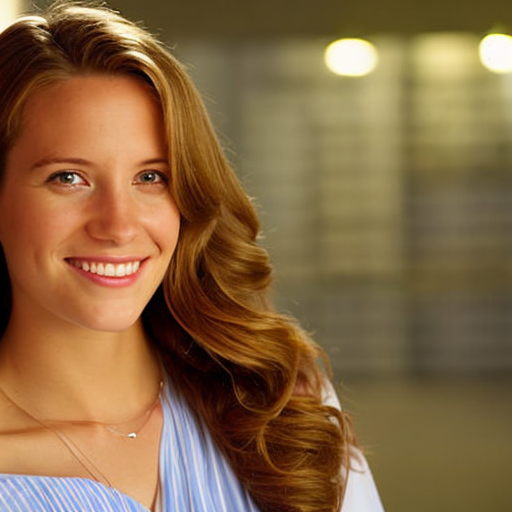

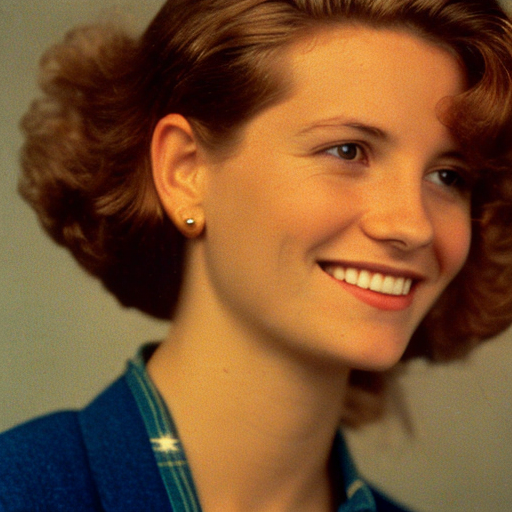

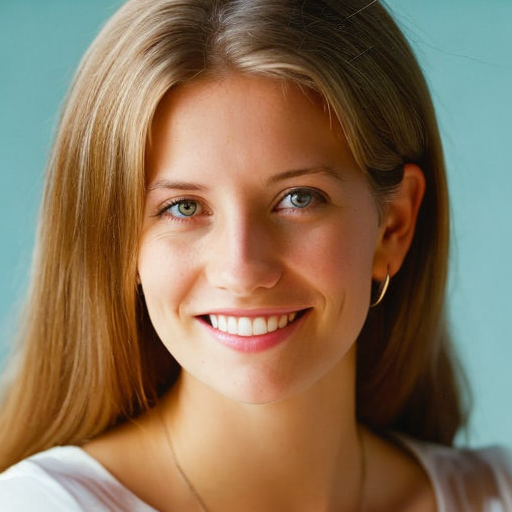

In [ ]:
positive_prompt = prompts_woman["1"]["positive_prompt"]
negative_prompt = prompts_woman["1"]["negative_prompt"]
num_images_per_prompt = 10
guidance_scale = 7.5
num_inference_steps = 70
height = 512
width = 512
#g_cuda = torch.Generator(device='cuda').manual_seed(1442)

images = pipe(
          prompt=positive_prompt,
          negative_prompt=negative_prompt,
          num_images_per_prompt=num_images_per_prompt,
          guidance_scale=guidance_scale,
          num_inference_steps=num_inference_steps,
          generator=g_cuda
      ).images

for image in images:
  display(image)

In [ ]:
del pipe

### Check in more detail

In [ ]:
import numpy as np
import PIL
PIL_INTERPOLATION = PIL.Image.LANCZOS

In [ ]:
# Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.preprocess
def preprocess(image):
    if isinstance(image, torch.Tensor):
        return image
    elif isinstance(image, PIL.Image.Image):
        image = [image]

    if isinstance(image[0], PIL.Image.Image):
        w, h = image[0].size
        w, h = map(lambda x: x - x % 8, (w, h))  # resize to integer multiple of 8

        image = [np.array(i.resize((w, h), resample=PIL_INTERPOLATION))[None, :] for i in image]
        image = np.concatenate(image, axis=0)
        image = np.array(image).astype(np.float32) / 255.0
        image = image.transpose(0, 3, 1, 2)
        image = 2.0 * image - 1.0
        image = torch.from_numpy(image)
    elif isinstance(image[0], torch.Tensor):
        image = torch.cat(image, dim=0)
    return image

In [ ]:
pipe.check_inputs(prompt, strength, 1)
batch_size = 1 if isinstance(prompt, str) else len(prompt)
device = pipe._execution_device
do_classifier_free_guidance = guidance_scale > 1.0

print("Device: ", device)
print("Batch size: ", batch_size)
print("Do classifier free guidance: ", do_classifier_free_guidance)

Device:  cuda:0
Batch size:  1
Do classifier free guidance:  True


In [ ]:
text_embeddings = pipe._encode_prompt(
        prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )
print("Text embeddings: ", text_embeddings.shape)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['hasselblad, candid street portrait']


Text embeddings:  torch.Size([20, 77, 1024])


In [ ]:
# 4. Prepare depth mask
depth_mask = pipe.prepare_depth_map(
    image,
    None,
    batch_size * num_images_per_prompt,
    do_classifier_free_guidance,
    text_embeddings.dtype,
    device,
)
print("Depth mask: ", depth_mask.shape)

Depth mask:  torch.Size([20, 1, 64, 64])


In [ ]:
# 5. Preprocess image
image = preprocess(image)
print("Image: ", image.shape)

Image:  torch.Size([1, 3, 512, 512])


In [ ]:
# 6. Set timesteps
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps, num_inference_steps = pipe.get_timesteps(num_inference_steps, strength, device)
print(f"Timesteps {timesteps} and num inference steps {num_inference_steps}")
latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)
print(f"Latent timestep {latent_timestep}")

Timesteps tensor([960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720, 700,
        680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440, 420,
        400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160, 140,
        120, 100,  80,  60,  40,  20,   0], device='cuda:0') and num inference steps 49
Latent timestep tensor([960, 960, 960, 960, 960, 960, 960, 960, 960, 960], device='cuda:0')


In [ ]:
# 7. Prepare latent variables
latents = pipe.prepare_latents(
    image, latent_timestep, batch_size, num_images_per_prompt, text_embeddings.dtype, device, g_cuda
)
print("Latents: ", latents.shape)

Latents:  torch.Size([10, 4, 64, 64])


In [ ]:
# 8. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
extra_step_kwargs = pipe.prepare_extra_step_kwargs(g_cuda, 0.0)
print("Extra kwargs: ", extra_step_kwargs)

Extra kwargs:  {'eta': 0.0, 'generator': <torch._C.Generator object at 0x7f33c3b78930>}


In [ ]:
# 9. Denoising loop
num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
print("Warmup steps: ", num_warmup_steps)

Warmup steps:  0


In [ ]:
with pipe.progress_bar(total=num_inference_steps) as progress_bar:
  for i, t in enumerate(timesteps):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    latent_model_input = torch.cat([latent_model_input, depth_mask], dim=1)

    # predict the noise residual
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    print("Predicted noise: ", noise_pred.shape)
    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample
    print("Latents: ", latents.shape)

    # call the callback, if provided
    if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
        progress_bar.update()

  0%|          | 0/49 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
# 10. Post-processing
image = self.decode_latents(latents)

# 11. Convert to PIL
if output_type == "pil":
    image = self.numpy_to_pil(image)

if not return_dict:
    return (image,)

In [ ]:
torch.cuda.empty_cache()